# **Image Caption Generator**
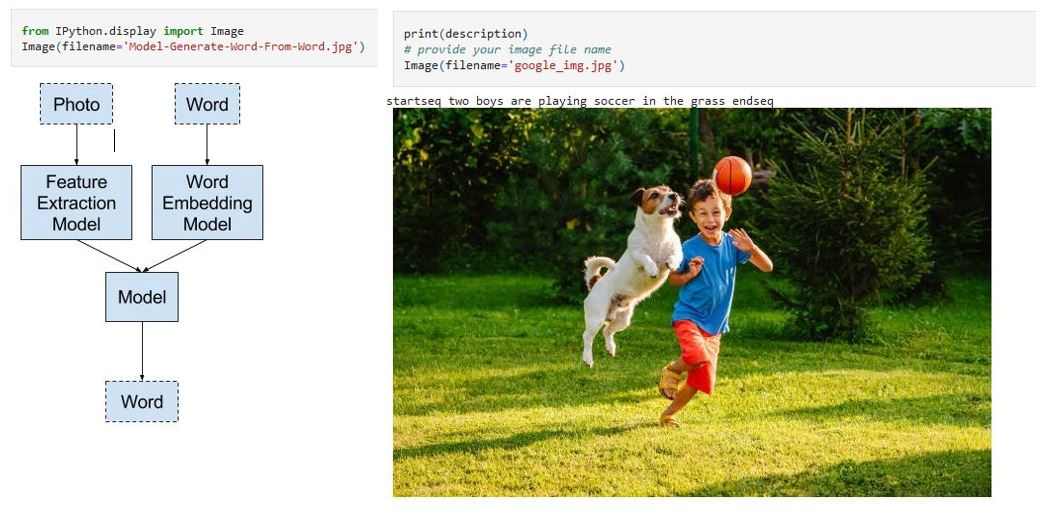

**Introduction to Image Captioning**

Image Captioning allows computers to describe the content of images using words. Just like we look at a picture and immediately understand what’s happening, computers can be trained to do the same!

For example, if you show a computer a picture of a cute cat, Image Captioning enables it to generate a sentence like, "A fluffy white cat is sitting on a windowsill." It’s an exciting combination of teaching machines to understand visual content and express it in natural language.

**How It Works**

Image Captioning relies on two key components that work together like a team of observer and storyteller:

1. **The Observer (Convolutional Neural Networks - CNNs)**:
Just as an observer carefully looks at a scene and notices the details, CNNs examine the image to detect important features like shapes, textures, and objects. These observations are transformed into vector embeddings, a numerical representation the computer can understand.

2. **The Storyteller (Recurrent Neural Networks - RNNs):**
The Storyteller takes the observations from the CNN and begins narrating a caption, word by word. It strings together the details detected by the observer, forming coherent sentences such as "A fluffy white cat is sitting on a windowsill."

**Why It’s Exciting**

Image Captioning enables machines to describe images in a human-like way, enhancing their visual understanding and communication abilities. For a visual representation of this process, see the Modeling section!

In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg

# **Importing Liberaries**

In [3]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm        # Progress bar library for Jupyter Notebook

# Deep learning framework for building and training models
import tensorflow as tf
## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

# For checking score
from nltk.translate.bleu_score import corpus_bleu

2025-09-07 09:35:18.613398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757237718.635435  654945 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757237718.642096  654945 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Setting the input and output directory
INPUT_DIR = '/kaggle/input/flickr8k'
OUTPUT_DIR = '/kaggle/working'

# Image Feature Extraction

To help the computer understand images, we rely on powerful pre-trained models. One such model is VGG16, which acts like a keen-eyed analyst, capable of identifying important details in pictures. It helps the model “see” and interpret what’s happening in an image.

# Why Choose VGG16?
VGG16 is widely used because it can capture both basic and intricate features of an image. Imagine it as a detective for visuals: it notices the cat’s pointy ears, the texture of its fluffy fur, and even the structure of the windowsill it’s sitting on.

By extracting these features, VGG16 provides a numerical representation of the image that can be combined with words. This allows our model to generate meaningful captions, essentially letting the computer narrate what it “sees” in the image.

Leveraging VGG16 makes image understanding efficient and accurate, setting the foundation for generating descriptive captions.

In [5]:
# We are going to use pretraind vgg model
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

I0000 00:00:1757237731.417613  654945 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757237731.418348  654945 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


# Extracting Image Features

In [6]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1757237747.522945  655000 service.cc:148] XLA service 0x7e6270006010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757237747.522972  655000 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757237747.522976  655000 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757237747.604710  655000 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757237749.540556  655000 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [8]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

In [9]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

# Loading Of Caption Data

In [10]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


**Dataset Overview**

There are a total of 40,455 captions corresponding to 8,091 images, which means each image has 5 different captions. This variety helps the model learn multiple ways to describe the same image.

# Preprocessing Captions: Preparing Them for the Model
Before generating captions, we need to clean and prepare the captions so that the model can understand them effectively. This step, called preprocessing, involves tasks such as:

i. Converting all text to lowercase

ii. Removing punctuation and special characters

iii. Adding start and end tokens to mark the beginning and  end of each caption

iv. Tokenizing words into numerical sequences that the model can process

Preprocessing ensures that our captions are in a format suitable for training the caption generation model.

In [11]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [12]:
# before preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['A black dog carries a green toy in his mouth as he walks through the grass .',
 'A black dog carrying something through the grass .',
 'A black dog has a blue toy in its mouth .',
 'A dog in grass with a blue item in his mouth .',
 'A wet black dog is carrying a green toy through the grass .']

In [13]:
# preprocess the text
clean(image_to_captions_mapping)

In [14]:
# after preprocess of text
image_to_captions_mapping['1026685415_0431cbf574']

['startseq black dog carries green toy in his mouth as he walks through the grass endseq',
 'startseq black dog carrying something through the grass endseq',
 'startseq black dog has blue toy in its mouth endseq',
 'startseq dog in grass with blue item in his mouth endseq',
 'startseq wet black dog is carrying green toy through the grass endseq']

In [15]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [18]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [19]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


# Preparing Training and Testing Data

In [20]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [52]:
# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys: 
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length,padding='post')[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        # Convert lists to NumPy arrays
                        X1_arr = np.array(X1_batch)
                        X2_arr = np.array(X2_batch)
                        y_arr = np.array(y_batch)
                        
                        # Yield a tuple of inputs and targets
                        yield ( (X1_arr, X2_arr), y_arr )

                        # Reset batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

# LSTM Model Training

With our image features ready, it’s time to bring the captions to life! In this section, we train the LSTM (Long Short-Term Memory) model, which is the core of our image caption generator.

The LSTM learns to generate descriptive captions word by word, combining the visual features from the image with the sequential understanding of language. This is where the model starts “telling stories” about the images.
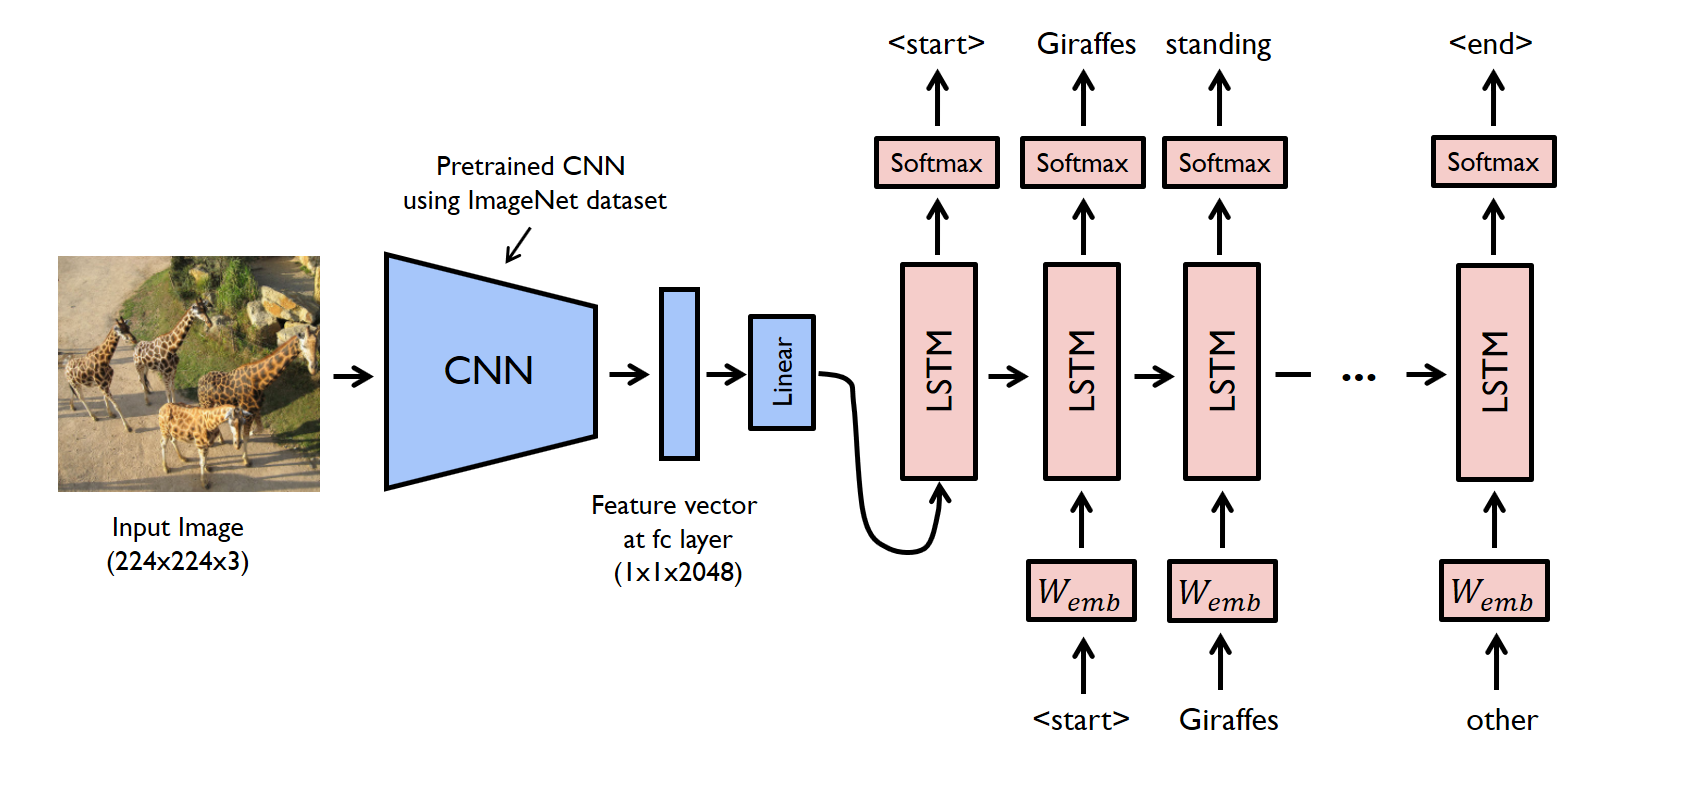
**During training:**

The model takes image features from CNNs as input.

It processes captions as sequences of words, predicting the next word in the sentence at each step.

The network is optimized to minimize prediction errors, gradually improving the quality of generated captions.

This stage is crucial for teaching the model how to connect visual elements with natural language, enabling it to describe unseen images effectively.

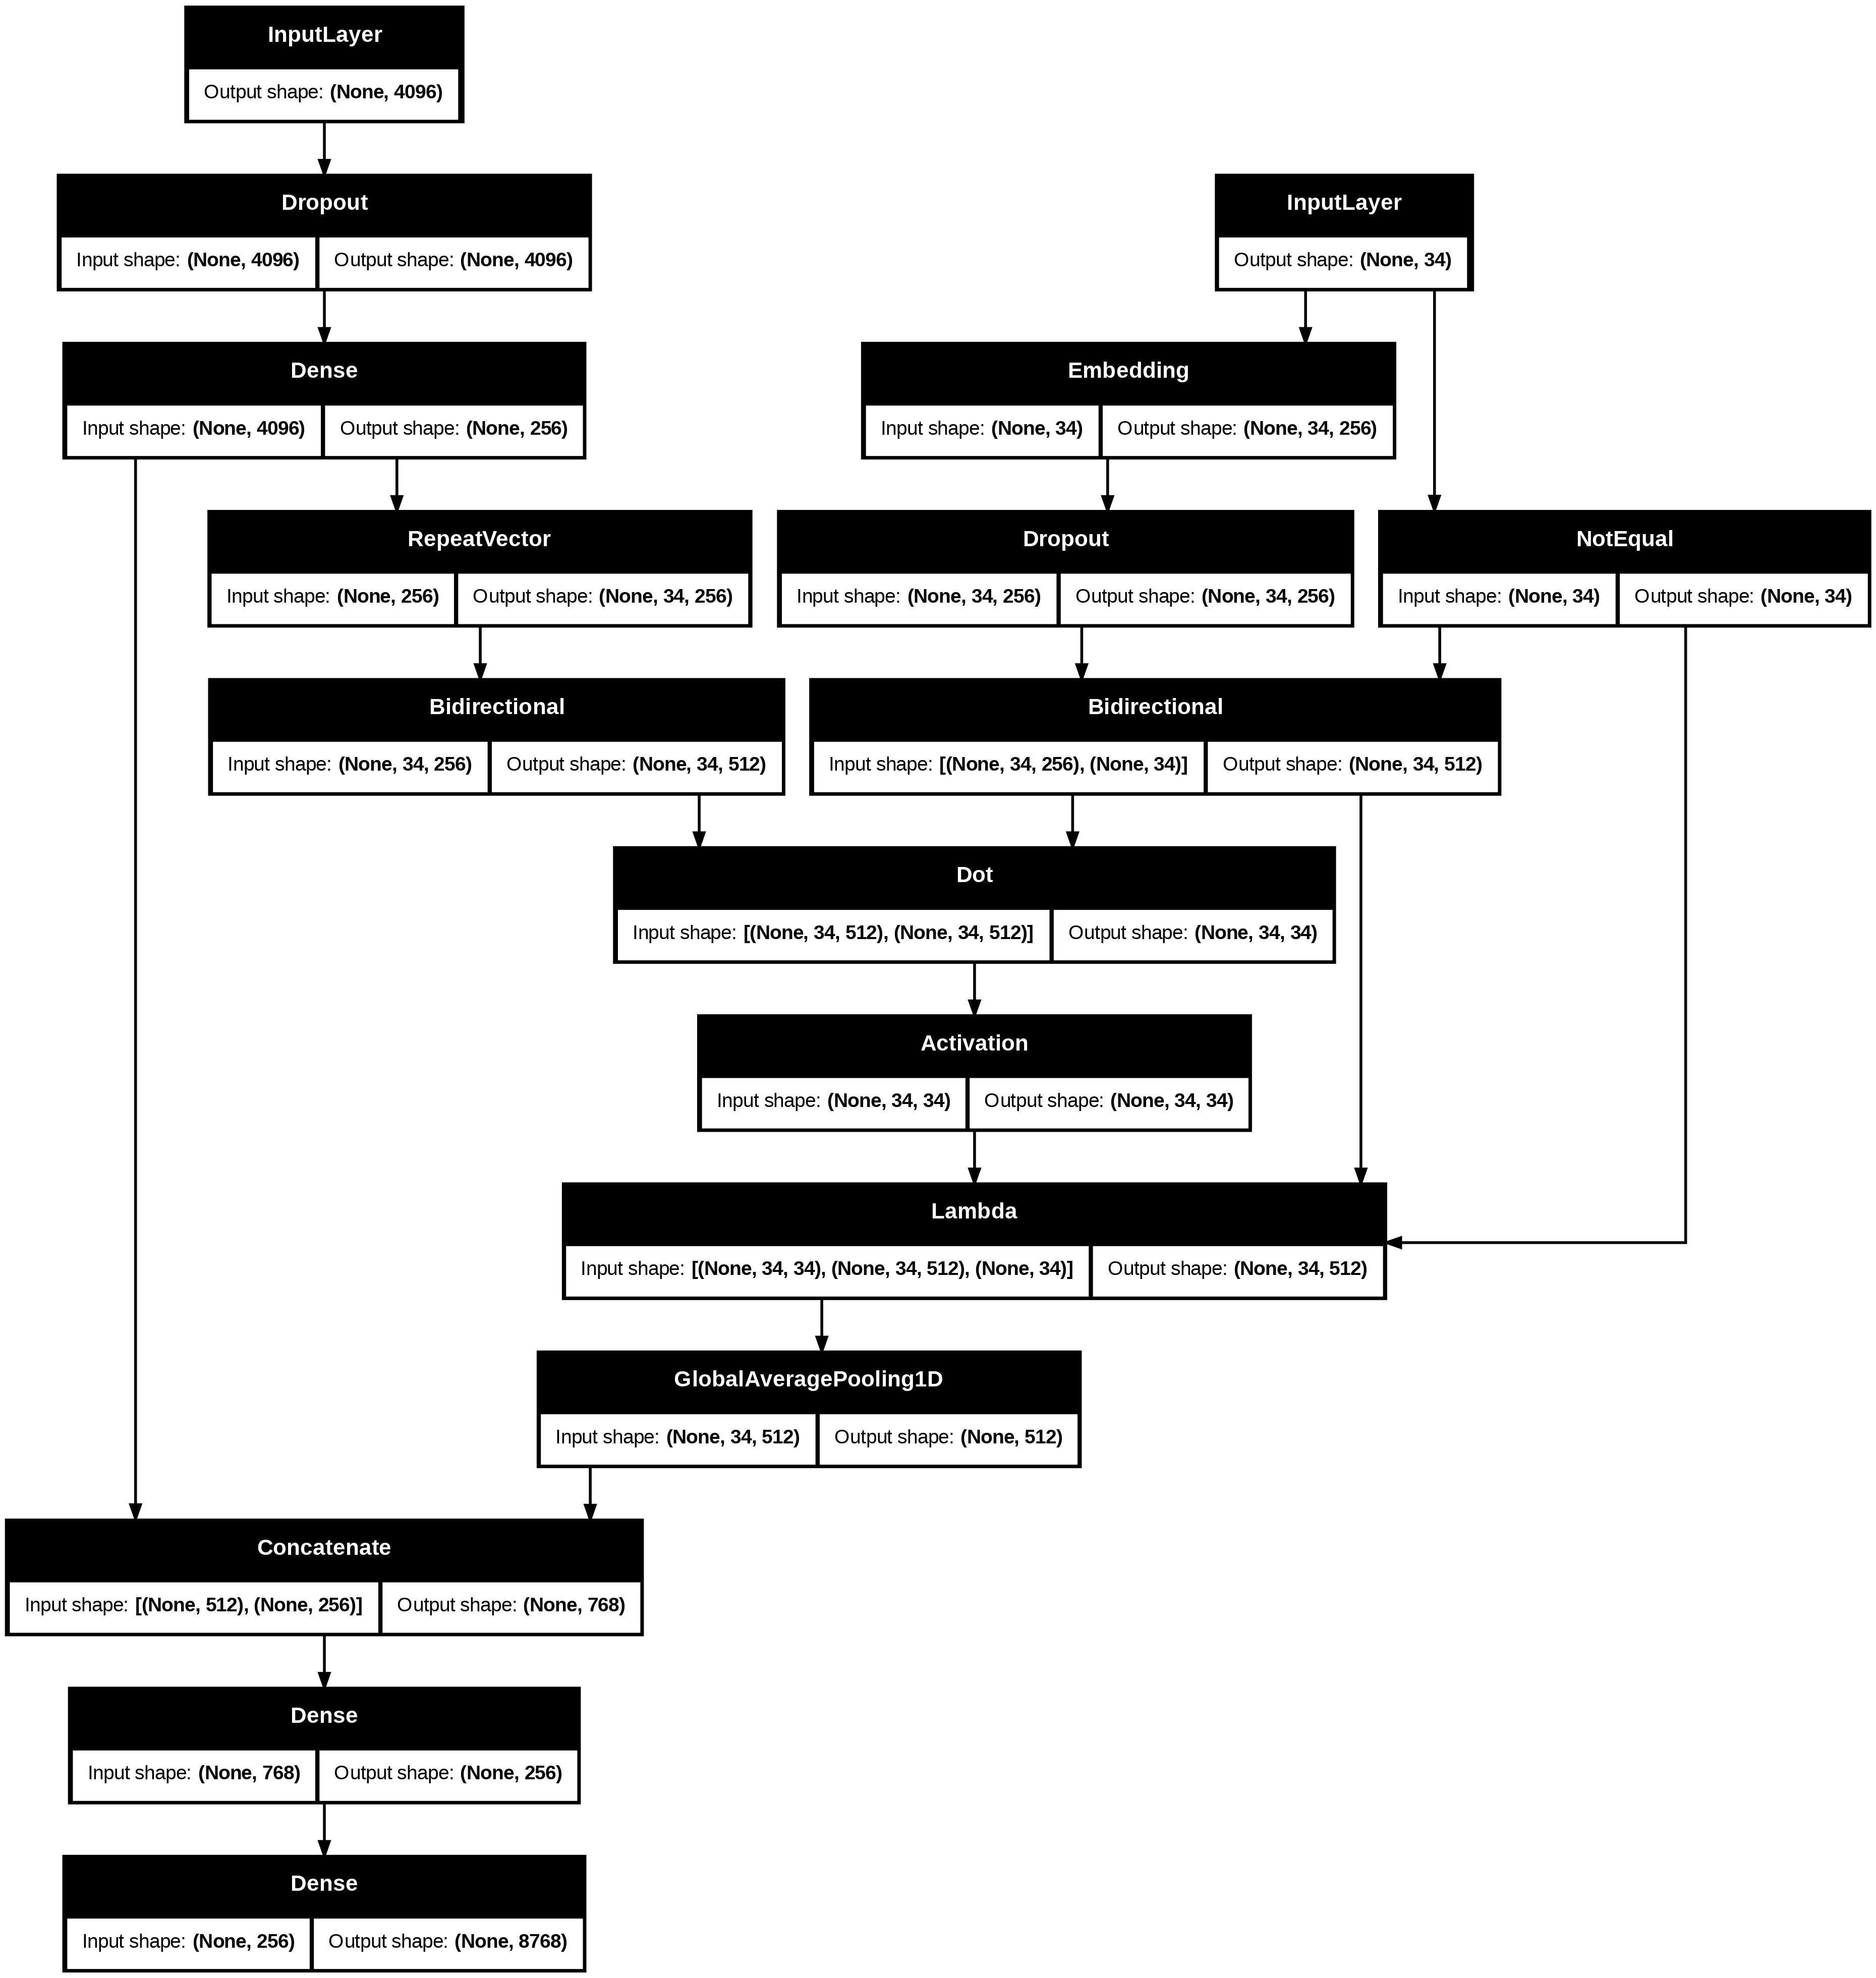

In [45]:
# Encoder model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Bidirectional, RepeatVector, Concatenate, Lambda, Dot, Activation, GlobalAveragePooling1D
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True, recurrent_activation='sigmoid', use_cudnn=False))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True, recurrent_activation='sigmoid', use_cudnn=False))(se2)

# Attention mechanism
attention = Dot(axes=[2, 2])([fe2_projected, se3])
attention_scores = Activation('softmax')(attention)
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])
context_vector = GlobalAveragePooling1D()(attention_context)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Complete model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize model
plot_model(model, show_shapes=True)

In [46]:
# Set the number of epochs, batch size
epochs = 50
batch_size = 32

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 6.8303 - val_loss: 6.2958
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 5.0942 - val_loss: 6.2193
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 4.7116 - val_loss: 6.3501
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 4.3042 - val_loss: 6.3015
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 4.1929 - val_loss: 6.8588
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.9999 - val_loss: 6.6174
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.8423 - val_loss: 6.8903
Epoch 8/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.7211 - val_loss: 6.9376
Epoch 9/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.4946 - val_loss: 6.8428
Epoch 10/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.3292 - val_loss: 6.8448
Epoch 11/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.1477 - val_loss: 6.6965
Epoch 12/50
228/228 ━━━━━━━━━━━━━━━━━━━━

In [47]:
# Save the model
model.save(OUTPUT_DIR+'/best_model.h5')

In [48]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [59]:
def predict_caption_beam(model, image_features, tokenizer, max_caption_length, beam_width=3):
    start_seq = ['startseq']
    sequences = [(start_seq, 0.0)]  # (sequence, score)

    for _ in range(max_caption_length):
        all_candidates = []
        for seq, score in sequences:
            # Convert sequence to indices
            sequence_indices = tokenizer.texts_to_sequences([' '.join(seq)])[0]
            sequence_indices = pad_sequences([sequence_indices], maxlen=max_caption_length, padding='post')
            
            # Predict next word probabilities
            yhat = model.predict([image_features, sequence_indices], verbose=0)[0]
            
            # Take top k candidates
            top_indices = np.argsort(yhat)[-beam_width:]
            for idx in top_indices:
                word = get_word_from_index(idx, tokenizer)
                if word is None or word == 'startseq':
                    continue
                candidate = (seq + [word], score - np.log(yhat[idx] + 1e-10))
                all_candidates.append(candidate)
        
        # Select top beam_width sequences
        sequences = sorted(all_candidates, key=lambda tup: tup[1])[:beam_width]

    best_seq = sequences[0][0]
    return ' '.join(best_seq)


In [60]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    
    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()
    
    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.397417
BLEU-2: 0.187873


# Predicting captions for Images

In [61]:
# Function for generating caption
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man skis skis displaying pictures in framed pictures set up in the snow endseq


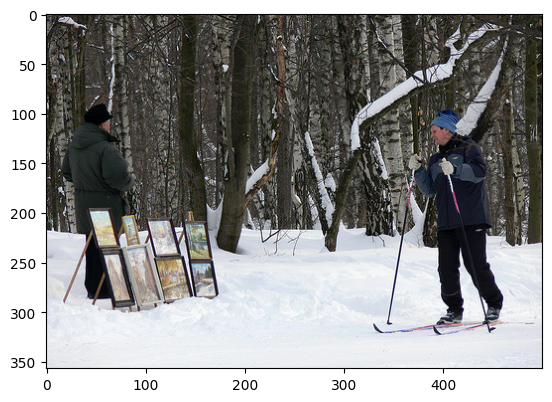

In [68]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
--------------------Predicted--------------------
startseq boy rides slide down slide into pool endseq


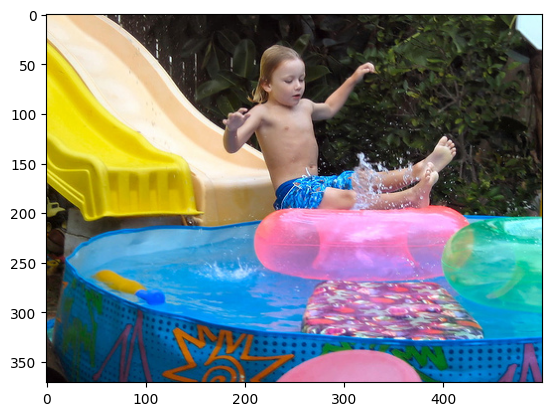

In [63]:
generate_caption("1077546505_a4f6c4daa9.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq young girl in pigtails sitting in front of canvas endseq


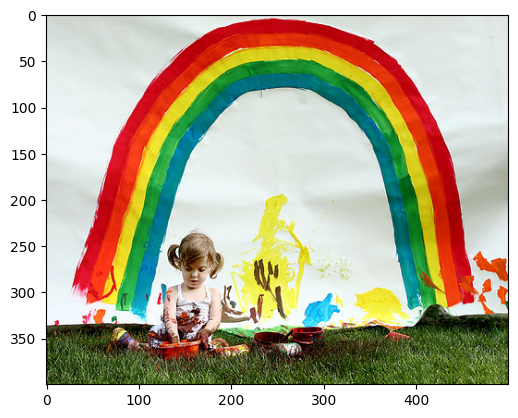

In [64]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man stands in front of skyscraper endseq


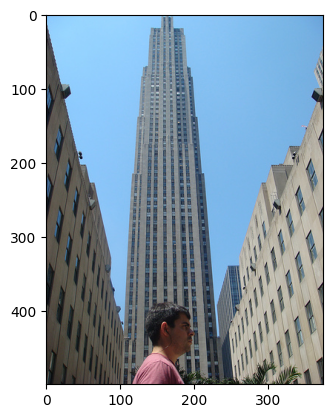

In [65]:
generate_caption("1032460886_4a598ed535.jpg")

# **Model Evaluation: BLEU Scores**

To evaluate how well our image caption generator performs, we use BLEU (Bilingual Evaluation Understudy) scores. BLEU is a popular metric that measures the similarity between the captions generated by the model and the actual human-written captions.

# **Results**

**BLEU-1: 0.397**

Measures unigram (single word) overlap between generated and reference captions.

A score of 0.397 indicates that roughly 40% of the individual words in the generated captions match the reference captions.

**BLEU-2: 0.188**

Measures bigram (two consecutive words) overlap, which also evaluates how well the model captures word sequences.

A score of 0.188 suggests that the model gets some word pairs right, but there’s still room for improvement in producing coherent phrases.

**Interpretation**

Higher BLEU scores indicate better similarity to human captions.

**BLEU-1** shows that the model is reasonably good at predicting individual words.

**BLEU-2** is lower, which is common in image captioning models, indicating that generating grammatically and contextually correct sequences is more challenging.